# Overview

To allow scientists to label their own PBMC datasets using the labels defined in our PBMC atlas, we provide models for CellTypist at each level of resolution.

AIFI_L1: 9 broad cell classes  
AIFI_L2: 29 major cell types  
AIFI_L3: 71 high-resolution cell types

These models can be obtained from the Downloads page. More information about CellTypist can be found in Domínguez Conde, et al. (2022) and at https://www.celltypist.org/.

For comparison to our CellTypist models, we'll also label cells with a model provided by the CellTypist website generated from data provided in Stephenson, et al. (2021).

# Demonstration

To demonstrate how to label your own data using our model, we'll label a PBMC dataset previously published in Swanson, et al. (2022) and available at GEO Accession GSM5513397.

This demonstration is written in Python, as CellTypist is available as a Python module. We also utilize the Scanpy package for single-cell data analysis, described in Wolf, et al. (2018).

## Setup for HISE usage

This section uses HISE to retrieve the CellTypist models. External users will need to retrieve models from the Downloads page of our website.

In [1]:
import hisepy
import os
import shutil

In [2]:
def read_path_uuid(file_uuid):
    file_path = '/home/jupyter/cache/{u}'.format(u = file_uuid)
    if not os.path.isdir(file_path):
        hise_res = hisepy.reader.cache_files([file_uuid])
    filename = os.listdir(file_path)[0]
    full_path = '{p}/{f}'.format(p = file_path, f = filename)
    return full_path

#### Model files

In [3]:
model_uuids = {
    'AIFI_L1': '482b9ec5-8631-48a1-a7ef-94e23fe97068',
    'AIFI_L2': 'cc78f20a-b962-4ddf-ae93-47d58741a644',
    'AIFI_L3': '671d1e43-bd32-4fea-bdda-d19a0484e664'
}

In [4]:
model_cache = {}
for name, uuid in model_uuids.items():
    model_cache[name] = read_path_uuid(uuid)

In [5]:
for loc in model_cache.values():
    shutil.copyfile(loc, os.path.basename(loc))

#### Colorsets

In [6]:
color_uuids = {
    'AIFI_L1': 'f06fcd94-834d-4490-b773-5cbb35760a51',
    'AIFI_L2': '36b6aa80-804e-4497-abe3-2d48e33bbdb5',
    'AIFI_L3': 'ee4b8ff6-3aa4-4bf0-841f-6d1b5fb284dd'
}

In [7]:
color_cache = {}
for name, uuid in color_uuids.items():
    color_cache[name] = read_path_uuid(uuid)

In [8]:
color_filenames = {
    'AIFI_L1': 'AIFI_L1_imm_health_atlas_type_order_colors.csv',
    'AIFI_L2': 'AIFI_L2_imm_health_atlas_type_order_colors.csv',
    'AIFI_L3': 'AIFI_L3_imm_health_atlas_type_order_colors.csv'
}

In [9]:
for level, loc in color_cache.items():
    shutil.copyfile(loc, color_filenames[level])

## Install required packages

In [10]:
!pip install -q scanpy
!pip install -q celltypist
!pip install -q session_info

## Load Modules

In [11]:
from urllib.request import urlretrieve

import celltypist
import pandas as pd
import scanpy as sc

## Specify CellTypist models

In addition to the AIFI CellTypist models, we'll use a Healthy PBMC model provided from the CellTypist model collection:

In [12]:
celltypist.models.download_models(
    force_update = True,
    model = ['Healthy_COVID19_PBMC.pkl']
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 50
📂 Storing models in /root/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Healthy_COVID19_PBMC.pkl


Here, we specify the path to the CellTypist models. For this demo, we assume the AIFI CellTypist models have been downloaded from the Downloads Page, and are placed in the working directory.

In [13]:
model_files = {
    'CellTypist_PBMC': 'Healthy_COVID19_PBMC.pkl',
    'AIFI_L1': 'ref_pbmc_clean_celltypist_model_AIFI_L1_2024-04-18.pkl',
    'AIFI_L2': 'ref_pbmc_clean_celltypist_model_AIFI_L2_2024-04-19.pkl',
    'AIFI_L3': 'ref_pbmc_clean_celltypist_model_AIFI_L3_2024-04-19.pkl'
}

## Download dataset from GEO

Next, we'll download the dataset we want to label from GEO. This .h5 file is provided as a Supplementary File in the GEO entry for GSM5513397

In [14]:
geo_url = ("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5513397&format=file&file=GSM5513397%5FW4%2Dhashed%2D24k%5Fcount%2Dmatrix%2Eh5")
h5_filename = "GSM5513397_W4-hashed-24k_count-matrix.h5"
urlretrieve(geo_url, h5_filename)

('GSM5513397_W4-hashed-24k_count-matrix.h5',
 <http.client.HTTPMessage at 0x7f064bfdacb0>)

## Load and normalize data with Scanpy

Next, we'll load the dataset using Scanpy, and normalize and log transform the data to meet the requirements of the CellTypist module for labeling.

In [15]:
adata = sc.read_10x_h5(h5_filename)
adata

AnnData object with n_obs × n_vars = 14478 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

Normalize and log scale data for labeling:

In [16]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

## Predict labels with each model

Now, we can loop through each model specified above and label the cells using CellTypist.

CellTypist provides multiple kinds of results about these labels. For this demo, we'll keep just the highest scoring label and the corresponding labeling score generated by CellTypist.

In [17]:
%%time

label_results = {}

for model_name, model in model_files.items():
    label_column = f'{model_name}_prediction'
    score_column = f'{model_name}_score'
    
    predictions = celltypist.annotate(
        adata, 
        model = model
    )
    
    labels = predictions.predicted_labels
    labels = labels.rename({'predicted_labels': label_column}, axis = 1)

    prob = predictions.probability_matrix
    prob_scores = []
    for i in range(labels.shape[0]):
        prob_scores.append(prob.loc[labels.index.to_list()[i],labels[label_column][i]])
    labels[score_column] = prob_scores

    label_results[model_name] = labels

🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3443 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 1099 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 1916 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🔬 Input data has 14478 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 2483 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


CPU times: user 17.9 s, sys: 17.4 s, total: 35.3 s
Wall time: 14.6 s


## Preview results for each model

After generating label predictions, let's look at the top 10 labels assigned by each of the labeling models:

In [18]:
for model_name, label_df in label_results.items():    
    label_column = f'{model_name}_prediction'
    label_summary = label_df[label_column].value_counts()
    print(label_summary[0:10], end = '\n\n')

CellTypist_PBMC_prediction
CD4.Naive         4661
CD14_mono         1976
CD8.Naive         1614
NK_16hi           1184
CD4.IL22           949
CD8.EM             615
B_naive            580
MAIT               432
CD83_CD14_mono     387
gdT                312
Name: count, dtype: int64

AIFI_L1_prediction
T cell             9955
Monocyte           1902
B cell             1423
NK cell            1119
DC                   45
Progenitor cell      22
ILC                  10
Erythrocyte           2
Name: count, dtype: int64

AIFI_L2_prediction
Memory CD4 T cell    3099
Naive CD4 T cell     2733
CD14 monocyte        2010
Naive CD8 T cell     1486
Memory CD8 T cell    1320
CD56dim NK cell      1009
Naive B cell          685
Memory B cell         557
MAIT                  339
Treg                  270
Name: count, dtype: int64

AIFI_L3_prediction
Core naive CD4 T cell               3112
Core naive CD8 T cell               1443
Core CD14 monocyte                  1377
GZMB- CD27+ EM CD4 T cell     

## Add labels to the dataset

In order to use the labels for visualization, as well as any downstream analyses we might want to do, we'll add the labels and scores from our celltypist labels to the AnnData object.

In [19]:
for model_name, label_df in label_results.items():    
    label_column = f'{model_name}_prediction'
    score_column = f'{model_name}_score'

    adata.obs[label_column] = label_df[label_column]
    adata.obs[score_column] = label_df[score_column]

## Dimensionality reduction for visualization

Next, we can perform dimensionality reduction with PCA and 2-dimensional projection with UMAP to allow us to visualize the labels on the data.

In [20]:
%%time
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.umap(adata)

CPU times: user 2min 29s, sys: 8min 6s, total: 10min 35s
Wall time: 41.8 s


## Optional: Add colorsets to AnnData
If you want to match the colors used in our publications, you can do so by reading the colorset tables we provide on our Downloads page.

In [21]:
color_files = {
    'AIFI_L1': 'AIFI_L1_imm_health_atlas_type_order_colors.csv',
    'AIFI_L2': 'AIFI_L2_imm_health_atlas_type_order_colors.csv',
    'AIFI_L3': 'AIFI_L3_imm_health_atlas_type_order_colors.csv'
}

In [22]:
color_dicts = {}
for level, file in color_files.items():
    color_df = pd.read_csv(file)
    color_dict = {}
    for i in range(color_df.shape[0]):
        cell_type = color_df[level].loc[i]
        type_color = color_df[f'{level}_color'].loc[i]
        color_dict[cell_type] = type_color
    color_dicts[level] = color_dict

In [23]:
for level, color_dict in color_dicts.items():
    color_order = adata.obs[f'{level}_prediction'].cat.categories
    level_colors = [color_dict[x] for x in color_order]
    adata.uns[f'{level}_prediction_colors'] = level_colors

## Plot labels on UMAP projections

Finally, let's plot the labeling scores and cell type labels from each CellTypist model.

Note: Due to the use of a multinomial regression for training of the AIFI_L3 model, the AIFI_L3_score values are higher than those for the other models.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


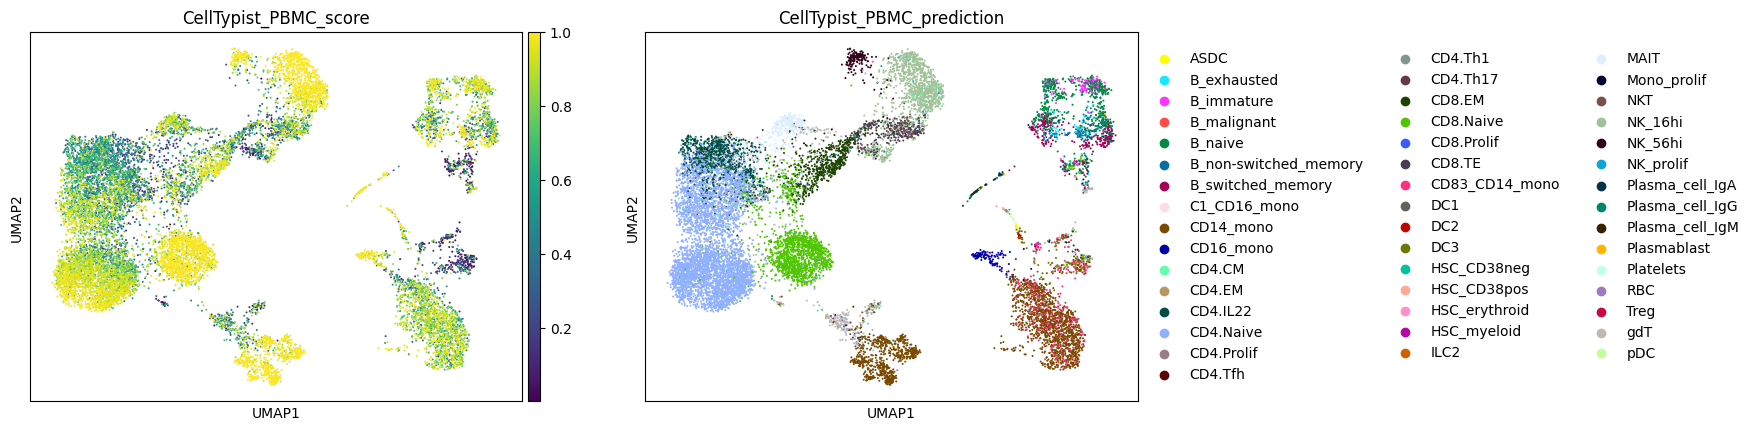

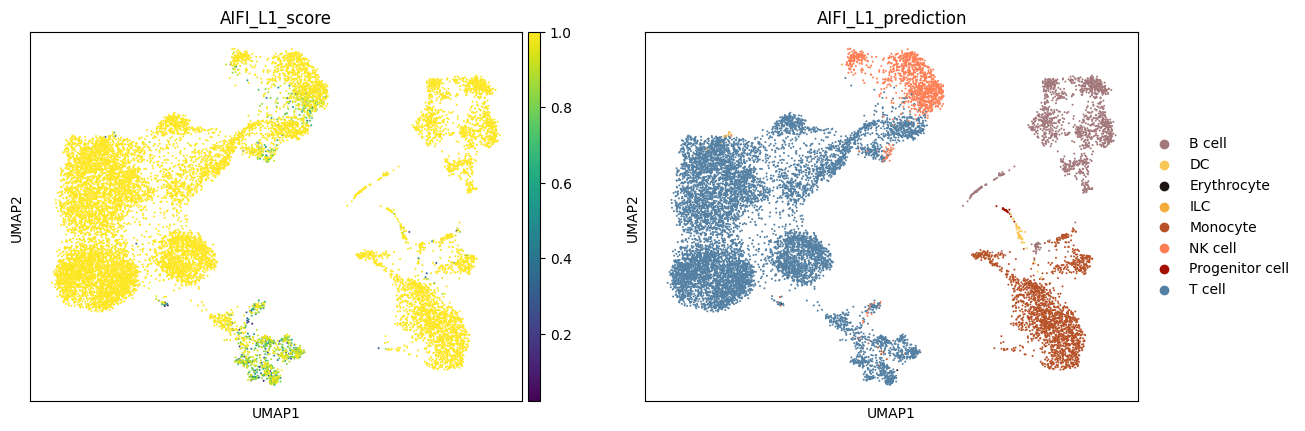

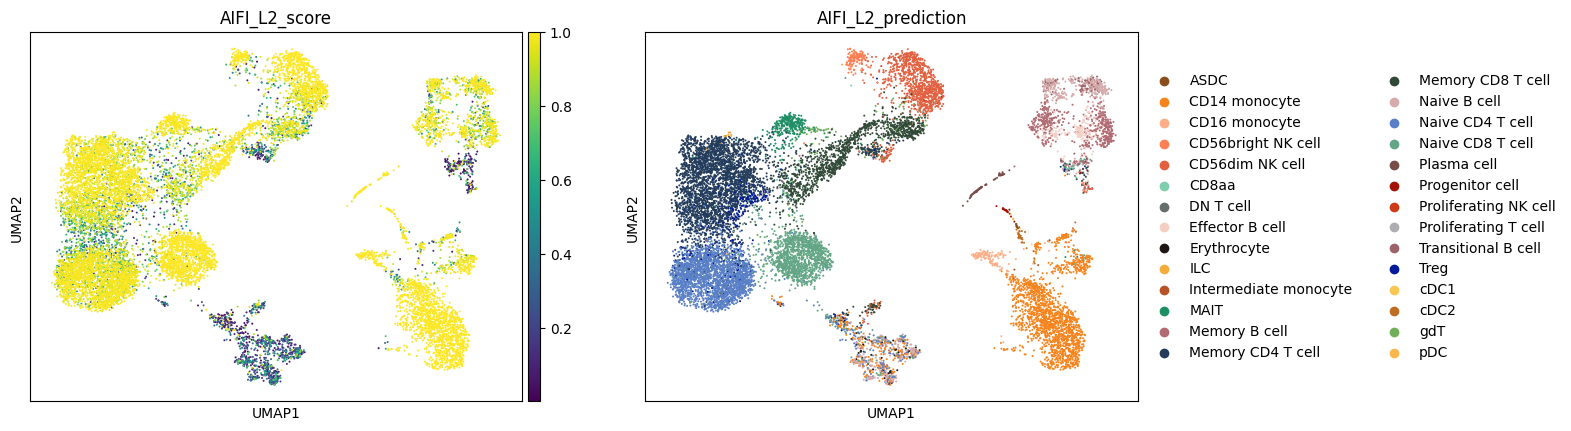

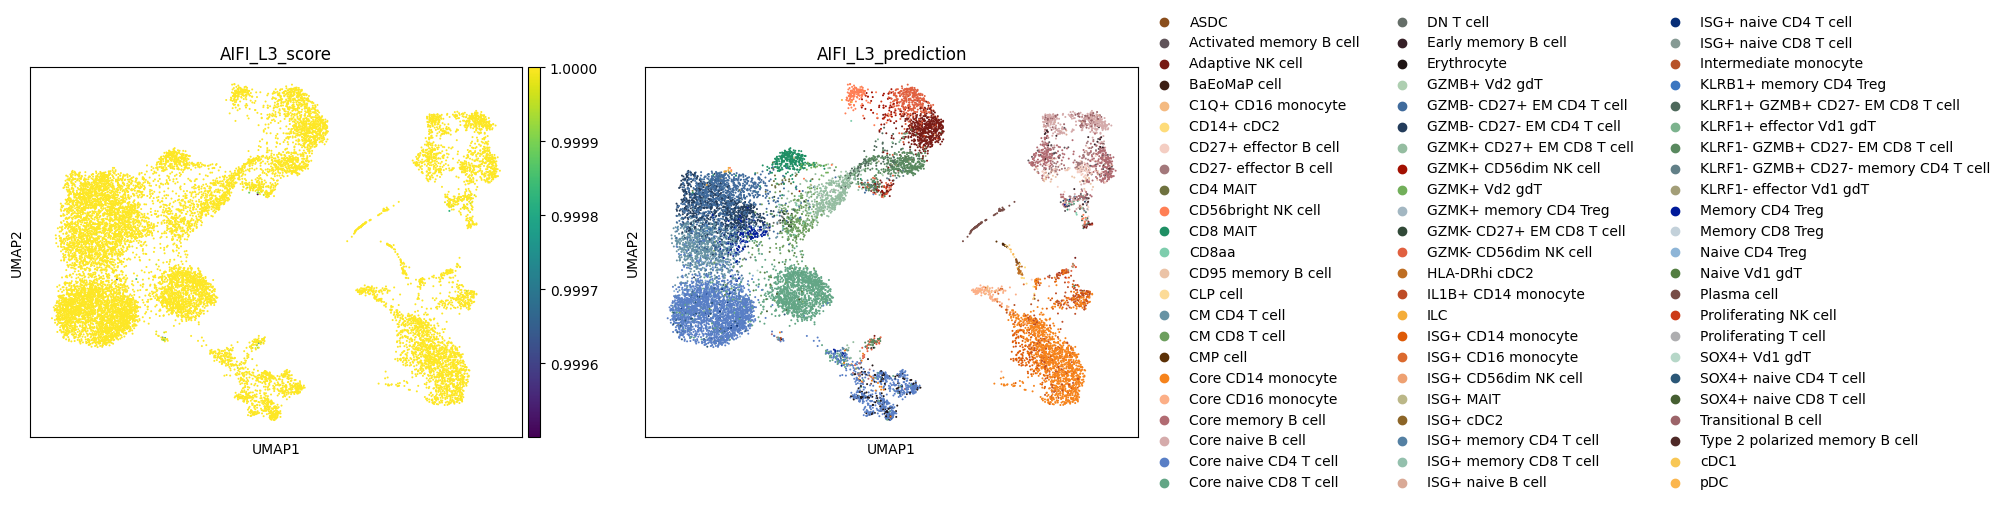

In [24]:
for model_name in label_results.keys():    
    label_column = f'{model_name}_prediction'
    score_column = f'{model_name}_score'
    
    sc.pl.umap(
        adata,
        color = [score_column, label_column]
    )

## Save labeled data

For later analysis, we can save the labeled dataset to disk as a .h5ad file.

In [25]:
adata.write_h5ad('labeled_GSM5513397_W4-hashed-24k_count-matrix.h5')

## Session Information

Below are details of the versions of Python and the Python Modules used for this demonstration.

In [26]:
import session_info
session_info.show()

## References
Domínguez Conde C, Xu C, Jarvis LB, Rainbow DB, Wells SB, Gomes T, et al. Cross-tissue immune cell analysis reveals tissue-specific features in humans. Science. 2022;376: eabl5197.
doi:10.1126/science.abl5197

Stephenson E, Reynolds G, Botting RA, Calero-Nieto FJ, Morgan MD, Tuong ZK, et al. Single-cell multi-omics analysis of the immune response in COVID-19. Nat Med. 2021;27: 904–916.
doi:10.1038/s41591-021-01329-2

Swanson E, Reading J, Graybuck LT, Skene PJ. BarWare: efficient software tools for barcoded single-cell genomics. BMC Bioinformatics. 2022;23: 106.
doi:10.1186/s12859-022-04620-2

Wolf FA, Angerer P, Theis FJ. SCANPY: large-scale single-cell gene expression data analysis. Genome Biol. 2018;19: 15.
doi:10.1186/s13059-017-1382-0